In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = pd.read_csv("C:\\Users\\aboser\\Documents\\GitHub\\PM_prediction\\Data\\Final_DFs\\Train.csv")

In [5]:
df.head()

,Unnamed: 0,Unique,Id,Day,Elevation,Emissions,Forest,Roads,Streets,Plumes_High,Plumes_Med,Plumes_Low,Max_Temp,Max_Wind,Precip,Rel_Humidity,Wind_Dir,BLH,AOD,PM
0,1,1131_1,1131,1,122.986002,0.0,0,0.0,0.191756,0,0,0,53.4,5.3,0.0,67.0,251.0,NaN,NaN,3.7
1,2,1131_100,1131,100,122.986002,0.0,0,0.0,0.191756,0,0,0,64.1,3.6,0.0,48.0,308.0,1155.824219,NaN,2.6
2,3,1131_101,1131,101,122.986002,0.0,0,0.0,0.191756,0,0,0,62.7,5.1,0.0,64.0,200.0,1162.292725,NaN,2.9
3,4,1131_102,1131,102,122.986002,0.0,0,0.0,0.191756,0,0,0,67.7,7.9,0.0,68.0,221.0,263.273407,NaN,0.5
4,5,1131_104,1131,104,122.986002,0.0,0,0.0,0.191756,0,0,0,60.1,6.5,0.0,44.0,314.0,1268.919434,0.097667,2.4


In [6]:
df.columns

Index(['Unnamed: 0', 'Unique', 'Id', 'Day', 'Elevation', 'Emissions', 'Forest',
       'Roads', 'Streets', 'Plumes_High', 'Plumes_Med', 'Plumes_Low',
       'Max_Temp', 'Max_Wind', 'Precip', 'Rel_Humidity', 'Wind_Dir', 'BLH',
       'AOD', 'PM'],
      dtype='object')

In [7]:
features = ['Day', 'Elevation', 'Emissions', 'Forest', 'Roads', 'Streets', 'Plumes_High', 
            'Plumes_Med', 'Plumes_Low', 'Max_Temp', 'Max_Wind', 'Precip', 'Rel_Humidity', 
            'Wind_Dir', 'BLH', 'AOD']

cat_features = [0, 3, 6, 7, 8]

target_col = 'PM'

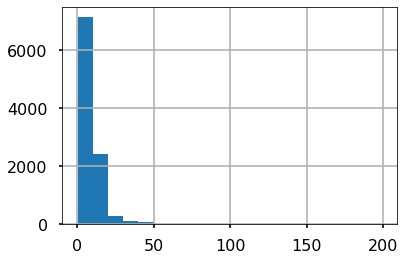

In [8]:
df['PM'].hist(bins=20)

In [11]:
import gc

import lightgbm as lgb

from sklearn.model_selection import GroupKFold


X = df[features]
y = df[target_col]

n_fold = 5

kf = GroupKFold(n_fold)
split = kf.split(X=X, y=y, groups=df['Id'])


params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 4,
    "num_leaves": 16,
    "num_iterations": 1000,
    "n_estimators": 1000,
    "categorical_feature": cat_features
}

n_boost_rounds = 1000
early_stopping_rounds = 200

train_pred = np.zeros((len(y)))
feature_importance_df = pd.DataFrame()
models = []

for i, (train_idx, test_idx) in enumerate(split):
    print(f'Starting training fold {i}.')
    _ = gc.collect()

    lgb_train = lgb.Dataset(X.loc[train_idx],
                            label=y.loc[train_idx])
    lgb_val = lgb.Dataset(X.loc[test_idx],
                          label=y.loc[test_idx])

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_val],
                      valid_names=['train', 'val'],
                      num_boost_round=n_boost_rounds,
                      early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=100)

    models.append(model)

    train_pred[test_idx] = model.predict(X.loc[test_idx], num_iteration=model.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model.feature_importance(importance_type='gain', 
                                                                iteration=model.best_iteration)
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

ModuleNotFoundError: No module named 'lightgbm'

In [12]:
from sklearn.metrics import r2_score

r2_score(y_true=df['PM'], y_pred=train_pred)

NameError: name 'train_pred' is not defined

In [13]:
import seaborn as sns

def display_importances(feature_importance_df_, save_file_path=None):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    fig = plt.figure(figsize=(14, 12))

    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    if save_file_path:
        plt.savefig(save_file_path) 

display_importances(feature_importance_df)

NameError: name 'feature_importance_df' is not defined

In [ ]:
df[df['PM'] < 50].groupby('Forest')['PM'].hist(bins=20, alpha=0.6, density=True)

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(df[features].corr())

In [ ]:
df.groupby('Day')['Rel_Humidity'].mean().plot()

#### Little SHAP analysis

In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(models[2])
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [ ]:
shap.dependence_plot("Elevation", shap_values, X)

In [ ]:
shap.dependence_plot("AOD", shap_values, X)

#### Conclusion from building baseline model:
0.67 is a good starting point for an R^2 we should be able to reach.  

Homework for Anna: Implement linear classifier here.  

This will involve:
1. Impute NaNs (or whatever you want to do).
2. Dummies for categorical features.
3. Normalize/standardize your data. (whatever the correct thing to do with linear models here is to handle skews and outliers and shit)
4. Train.

In [ ]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression() # set params (regularize?)

# how you can do grouped cross val
X = df[features]
y = df[target_col]

n_fold = 5

kf = GroupKFold(n_fold)
split = kf.split(X=X, y=y, groups=df['Id'])

for i, (train_idx, test_idx) in enumerate(split):
    print(f'Starting training fold {i}.')
    _ = gc.collect() # runs garbage collection (frees memory)

    X_train = X.loc[train_idx] # grabbing training explamples for this fold in CV.
    y_train = y.loc[train_idx]
    
    #grab validation data
    X_val = X.loc[test_idx]
    y_val = y.loc[test_idx]
    
    lgb_train = lgb.Dataset(X.loc[train_idx],
                            label=y.loc[train_idx])
    lgb_val = lgb.Dataset(X.loc[test_idx],
                          label=y.loc[test_idx])